# Expectation model
This notebook describes the expectation model for predicting the proportion of observed variants for a given sequence mutability. 

It first combines annotations for possible variants, observed variants, VEP annotations and trinucleotide contexts. 

The proportion of synonymous variants observed in each trinucleotide context is then calculated, and an exponential  model is built to describe the relationship between mutability and proportion observed.

## Preliminaries

### Install libraries to cloud worker

In [31]:
! conda install statsmodels -y
! conda install scikit-learn -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 23.1.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joblib-1.0.1               |     pyhd3eb1b0_0         208 KB
    scikit-learn-0.24.2        

### Download data from UKB RAP

In [2]:
%%bash
dx download \
    -f \
    -o ../data/ \
    data/cds_trinucleotide_contexts.tsv \
    data/grch38_cpg_methylation.tsv \
    data/gnomad_nc_mutation_rates.tsv \
    data/vep_cds_all_possible_snvs.vcf \
    outputs/gnomad_pass_variants/all_pass_snvs.txt

### Import modules

In [32]:
# Import modules
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

# Set seaborn context
sns.set_context("talk")

## Load datasets

In [4]:
# Define VCF headers and datatypes.
_header = ["chr", "pos", "id", "ref", "alt", "qual", "filter", "info"]

datatypes = defaultdict(lambda: "str")
datatypes.update({"pos": np.int32, "ac": np.int32, "an": np.int32})

In [5]:
# Retreive observed variants
obs = pd.read_csv(
    "../data/all_pass_snvs.txt",
    sep="\t",
    header=None,
    names=_header + ["ac", "an"],
    usecols=["chr", "pos", "ref", "alt", "ac", "an"],
    dtype=datatypes,
).assign(obs=1)

In [6]:
# Retreive all possible SNVs
pos = pd.read_csv(
    "../data/vep_cds_all_possible_snvs.vcf",
    sep="\t",
    comment="#",
    header=None,
    names=_header,
    dtype=datatypes,
    usecols=["chr", "pos", "ref", "alt"],
)

In [7]:
# Retreive VEP annotations of all possible SNVs
vep = pd.read_csv(
    "../data/vep_cds_all_possible_snvs.vcf",
    sep="\t",
    comment="#",
    header=None,
    names=_header,
    dtype=datatypes,
    usecols=["chr", "pos", "ref", "alt", "info"],
)

In [8]:
# Limit to synonymous variants only
syn = pd.Series(["synonymous" in x for x in vep["info"]])
vep = vep.drop("info", axis=1).loc[syn].assign(csq="synonymous")

In [9]:
# Trinucleotide contexts
tri = pd.read_csv(
    "../data/cds_trinucleotide_contexts.tsv", sep="\t", dtype=datatypes
)

In [10]:
# gnomAD methylation data
meth = (pd.read_csv("../data/grch38_cpg_methylation.tsv", 
                    sep="\t",
                    header=0,
                    names=["ix","chr","pos","alleles","lvl"],
                    usecols=["chr","pos","lvl"],
                   )
       )

In [11]:
# Mutation rates
mu = pd.read_csv(
    "../data/gnomad_nc_mutation_rates.tsv",
    sep="\t",
    names=["tri", "ref", "alt", "lvl", "variant_type", "mu", "pos", "obs", "po", "ppo",],
    header=0,
    usecols=["tri", "ref", "alt", "lvl", "mu", "variant_type"],
)

# Mutation rates are only available for 32 codons. We need to reverse-complement for the remainder.
complement = {"A": "T", "C": "G", "G": "C", "T": "A"}
# Replace ref and alt alleles
_mu = mu.copy().replace(complement)
# Reverse-complement trinucleotide contexts
_mu["tri"] = pd.Series(["".join([complement[y] for y in x])[::-1] for x in mu.tri])
mu = pd.concat([mu, _mu])

## Merge annotations

In [12]:
# Merge variant annotations
df = pos.merge(obs, how="left").fillna(0)
df = df.merge(vep, how="left").dropna()
df = df.merge(tri, how="left")

In [14]:
# Merge methylation and mutability annotations

## Find the number of CpG sites not represented in the ENCODE data
variant_types = mu[["tri", "ref", "alt", "variant_type"]].drop_duplicates()
df = df.merge(variant_types, how="left")
df = df.merge(meth, how="left")

## All non-CpG sites have lvl 0
df.loc[df["variant_type"] != "CpG", "lvl"] = 0
df.lvl = df.lvl.astype(int)

## Merge with mutability data
df = df.merge(mu, how="left")

### Make a copy of the dataframe in case it is needed

In [15]:
df_spare = df.copy()

## Drop selected variants

In [16]:
# Drop contexts in which a synonymous variant is generally not possible.
# (Synonymous variants in these contexts may occur at splice junctions)
m1 = (df.tri == "AGT") & ((df.alt == "C") | (df.alt == "T"))
m2 = (df.tri == "AAT") & ((df.alt == "C") | (df.alt == "T"))
m3 = (df.tri == "ACT") & ((df.alt == "G") | (df.alt == "A"))
m4 = (df.tri == "ATT") & ((df.alt == "G") | (df.alt == "A"))

df = df[~(m1 | m2 | m3 | m4)]

In [17]:
# Drop common variants
df = df[(df["ac"] == 0) | (df["ac"] / df["an"] < 0.001)]

## Statistics

In [18]:
stats = (
    df.groupby(["tri", "ref", "alt", "lvl"])
    .agg({"mu": "mean", "obs": "mean", "pos": "count"})
    .reset_index()
)
stats.to_csv("../outputs/mutational_model_stats.tsv", sep="\t", index=False)

## Plots

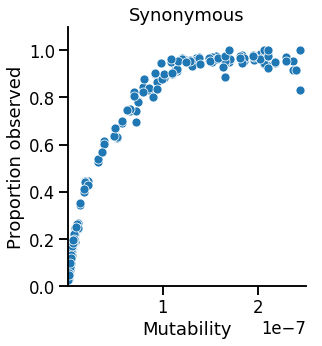

In [19]:
g = (sns.relplot(kind="scatter",
                 data=stats,
                 x="mu",
                 y="obs",
                )
    )
(g.set(xlim=(8.9*10**-10, 2.5*10**-7),
       ylim=(0,1.1),
       title="Synonymous",
       xlabel="Mutability",
       ylabel="Proportion observed",
      )
)

This looks like a nice exponential relationship which caps at 1. (The proportion of observed variants can't be >1).

I want to fit a curve which describes this relationship. Later, I want to use this model to predict "obs" (the proportion observed) for other values of "mu" (mutability).

## Exponential model

### Drop saturated contexts

In [33]:
print(f"Contexts = {len(stats)}")
print(f'There are {(stats["obs"]==1).sum()} observations for which "obs" == 1. Drop them.')

# Drop saturated contexts
stats_nonsat = stats[stats["obs"] != 1].copy()
print(f"Contexts remaining = {len(stats_nonsat)}")

Contexts = 304
There are 5 observations for which "obs" == 1. Drop them.
Contexts remaining = 299


## Fit the model

The approach below matches that in from the gnomAD code base at https://github.com/atgu/gnomad_nc_constraint

In [34]:
# A function to retrieve the standard error of a proportion
def sem(p, n): return np.sqrt((p*(1-p))/n)

In [35]:
# Fit a polynomial equation
fit = np.polyfit(stats_nonsat["mu"], np.log(1 - stats_nonsat["obs"]), 1, w=(1/sem(stats_nonsat["obs"], stats_nonsat["pos"])))
# Weighted by 1 / sem("obs"), as per gnomAD paper
# Weighting by "pos" is also reasonable

# Create a polynomial evaluator
p = np.poly1d(fit)

A,B = fit # Get the coefficients
print(f"A = {A}")
print(f"B = {B}")

# The expressions below are equivalent - both are given for clarity
stats_nonsat["fit_obs"] = 1 - (np.exp(B)) * (np.exp(A * stats_nonsat["mu"]))
stats_nonsat["fit_obs"] = 1 - np.exp(p(stats_nonsat["mu"]))

# R2 for "obs" vs "fit_obs"
print(f'R2 = {np.round(r2_score(stats_nonsat["obs"], stats_nonsat["fit_obs"]), 5)} for "obs" vs "fit_obs"')

A = -23025162.179456078
B = -0.023470852796130738
R2 = 0.9939 for "obs" vs "fit_obs"


### Plots 

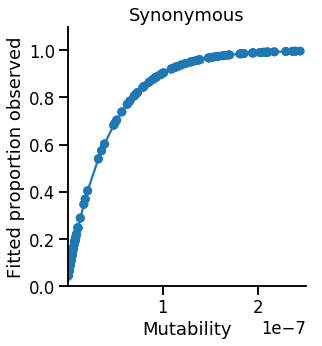

In [36]:
# Plot "mu" vs "fit_obs"
g = (sns.relplot(kind="scatter",
                 data=stats_nonsat,
                 x="mu",
                 y="fit_obs",
                 edgecolor="none",
               )
    )

# Modify figure
(g.set(xlim=(8.9*10**-10, 2.5*10**-7),
       ylim=(0,1.1),
       title="Synonymous",
       xlabel="Mutability",
       ylabel="Fitted proportion observed",
      )
)

# Add trend line
plt.plot(sorted(stats_nonsat["mu"]), sorted(stats_nonsat["fit_obs"]))

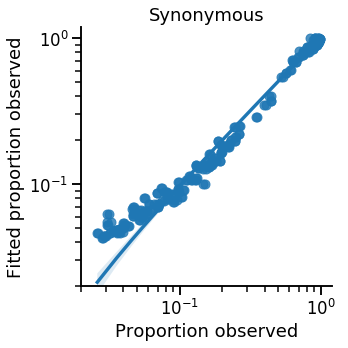

In [37]:
# Plot "obs" vs "fit_obs"
g = sns.lmplot(data=stats_nonsat, x="obs", y="fit_obs")
(g.set(title="Synonymous", 
       xlabel = "Proportion observed", 
       ylabel="Fitted proportion observed", 
       xscale="log", 
       yscale="log",
       xlim=(0.02, 1.2),
       ylim=(0.02, 1.2),
      )
)